In [1]:
#LSTM caso 1: MULTIVADIARO - MULTISTEP
import pyodbc
import pandas as pd
from datetime import date, datetime, timedelta
import numpy as np
from dateutil.relativedelta import relativedelta
import matplotlib.pylab as plt
%matplotlib inline
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, LSTM, Embedding, Input, Concatenate, Reshape
from keras.optimizers import SGD, RMSprop
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import IsolationForest
from IPython.display import display

plt.rcParams['figure.figsize' ] = (16, 9)
plt.style.use('fast')

In [2]:
#LINEA DE SQL SERVER PARA MODO PRUEBA (SERVIDOR EXTERO)

# sql_server = """
# DRIVER={ODBC Driver 17 for SQL Server};
# server=192.168.1.235,1433;
# database=AdventureWorksDW2022;
# uid=sa;
# pwd=qwerty;
# Trusted_connection=yes;
# """

In [3]:
#LINEA DE CONEXIÓN PARA SQL SERVER EN MODO PRUEBA (SERVIDOR LOCAL)
sql_server = """
DRIVER={ODBC Driver 17 for SQL Server};
server=US3RN4M3;
database=AdventureWorksDW2022;
Trusted_connection=yes;
"""

In [4]:
query = """
SELECT
    CAST(OrderDate AS DATE) AS Date
    ,YEAR([OrderDate]) AS [YEAR]
    ,MONTH([OrderDate]) AS [MONTH]
    ,DAY([OrderDate]) AS [Day]
    ,DATEPART(weekday, [OrderDate]) - 1 AS [DayOfWeek]
    ,CASE
        WHEN DATEPART(weekday, [OrderDate]) IN (7, 1) THEN 1
        ELSE 0
    END AS IsWeekend
    ,[ProductKey]
    ,Sum([OrderQuantity]) AS OrderQuantity
    ,Sum([UnitPrice]) AS UnitPrice
    ,Sum([UnitPriceDiscountPct]) As UnitPriceDiscountPct
    ,Sum([DiscountAmount]) AS DiscountAmount
    ,Sum([ProductStandardCost]) AS ProductStandardCost
    ,Sum([SalesAmount]) AS SalesAmount
    FROM [AdventureWorksDW2022].[dbo].[FactInternetSales]
    WHERE
    [FactInternetSales].OrderDate < '2013-12-01'
    group by YEAR([OrderDate]),MONTH([OrderDate]),DAY([OrderDate]),DATENAME(weekday,[OrderDate]),[OrderDate],[ProductKey]
    order by YEAR([OrderDate]) ASC,MONTH([OrderDate]) ASC,DAY([OrderDate]) ASC
"""

In [5]:
query2 = """
SELECT 
    CAST(f.OrderDate AS DATE) AS sales_date,
    CAST(SUM(f.OrderQuantity) AS INT) AS TotalVentas
FROM 
    FactInternetSales AS f
WHERE 
    f.OrderDate > '2013-11-30'
    AND f.OrderDate < '2014-01-01'
    AND f.ProductKey = 214  
GROUP BY 
    CAST(f.OrderDate AS DATE)
ORDER BY 
    CAST(f.OrderDate AS DATE) ASC;
"""

In [6]:
queryProducts = """
SELECT
    p.ProductKey,
    p.StandardCost,
    p.ListPrice AS Price
FROM
    DimProduct AS p
WHERE
    p.ProductKey IS NOT NULL 
	AND p.StandardCost IS NOT NULL
	AND p.ListPrice IS NOT NULL;
"""

In [7]:
#CONSTANTES E HIPERPARÁMETROS PARA LSTM

PASOS = 180 # No. DE OBSERVACIONES EN EL TIEMPO PARA LA DATA Y PARA ALGORITMO DE 'SLIDDING WINDOW'
TRAINING_PERCENTAGE = 0.9  #PORCENTAJE DE DATOS A TOMAR PARA ENTRENAMIENTO
N_PREDICTIONS = 31  #NUMERO DE PREDICCIONES A REALIZAR
EPOCHS = 30 #EPOCAS DE ENTRENAMIENTO DEL MODELO
NEURONS = 100 #Mismo que el de pasos
BATCH_SIZE = 15 #TAMANIO DE LAS MUESTRAS DE ENTRENAMIENTO
ISFLOATDATA = True #VARIABLE QUE CONVIERTE LOS DATOS A PUNTO FLOTANTE


#VARIABLES PARA TRATAMIENTO DE DATA
# GROUP_ID = 'ProductKey_encoded'


#NOTAS DE ESTA PARTE: el número de pasos no es correlativo al No. de predicciones
#ya que, las predicciones pudieran ser de 61 días y el No. de pasos siempre serán 31, ya que bajo
#ese proceso se hizo el entrenamiento

In [8]:
def get_sqlconnection():
    """
    Método para realizar conexión hacia el servidor de la base de datos de donde extraer la data
    """
    status = "inicializando...."
    try: 
        connection = pyodbc.connect(sql_server)
        status = "Conexion establecida satisfactoriamente"
    except Exception as e:
        status = "Error al establecer la conexión:"+e
    print(status)
    return connection

In [9]:
def set_index_datetime(data):
        """
        Elimina la columna numérica original y setea la nueva columna como index
        """
        if str(type(data) == "<class 'pandas.core.frame.DataFrame'>"):
            # data.sort_values('fecha', inplace=True)
            for column in data.columns: 
                try: 
                    pd.to_datetime(data[column])
                    data.set_index(column,inplace=True)
                    return data
                except Exception as e:  
                    pass
        else: 
            return 0

In [10]:
def split_sequences(df, input_steps, output_steps, features, target):
    """
    Divide la secuencia multivariante en muestras para LSTM, permitiendo ventanas de entrada y salida de diferente tamaño.
    """
    X, y = [], []
    datos = df[features].values
    target_vals = df[target].values
    for i in range(len(datos) - input_steps - output_steps + 1):
        X.append(datos[i:i+input_steps])
        y.append(target_vals[i+input_steps:i+input_steps+output_steps])
    return np.array(X), np.array(y)


In [11]:
def tratamiento_datos(data, columns, features, target_col, new_col, productkeyIds,dataProduct, GROUP_ID, show_nan=False, show_data_output=False):
    """
    Realiza una mejora y garantiza la secuencia temporal de los datos a manejar para LSTM
    """

    val = data.copy()
    val = val.reset_index()
    series_modified = []

    #obtener la fecha inicial
    for i, group in val.groupby(GROUP_ID):

        #obtenemos el productKeyActual
        producK_ID = group[GROUP_ID].iloc[0]

        #obtenemos el productkey
        productID = group['ProductKey'].iloc[0]

        #obtener la fecha inicial
        date_ini = group['Date'].min()

        #obtener la fecha final
        date_last = group['Date'].max()

        #Comvertimos la columna 'Date' a datetime
        group['Date'] = pd.to_datetime(group['Date'], errors='coerce')

        #ordenamos la columna
        group = group.sort_values('Date')
        
        #filtramos y obtenemos los valores únicamente en el rango establecido
        group = group[(group['Date']>= pd.Timestamp(date_ini)) & (group['Date']<=pd.Timestamp(date_last))]

        #seteamos como index
        group_index = group.set_index('Date')

        #Creamos el rango que debería tener lo ya establecido
        days_corrected = pd.date_range(start=date_ini, end=date_last - pd.Timedelta(days=1), freq='D')

        #Reindexamos para poder garantizar continuidad (rellenamos los días faltantes)
        group_reindex = group_index.reindex(days_corrected)

        if show_nan:
            #Comprobamos, debe haber NaN o NA
            print(group_reindex)

        #PASO 2: RELLENAR EL RESTO DE COLUMNAS FALTANTES
        group_reindex = group_reindex.reset_index()

        #Rellenar columnas relacionado a la fecha
        group_reindex['YEAR'] = group_reindex['index'].dt.year
        group_reindex['MONTH'] = group_reindex['index'].dt.month
        group_reindex['Day'] = group_reindex['index'].dt.day
        group_reindex['DayOfWeek'] = group_reindex['index'].dt.dayofweek
        group_reindex['IsWeekend'] = group_reindex['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

        #setear index
        group_reindex = group_reindex.set_index('index')

        #COLUMNA TARGET
        group_reindex[target_col] = group_reindex[target_col].fillna(0)

        #Asegurarnos de que es de tipo int
        group_reindex[target_col] = group_reindex[target_col].astype(int)

        #============================ PARTES PARA RELLENAR PRECIO UNITARIO Y DE ENVIO
        # Obtenemos el precio unitario
        # precioUNitario = dataProduct[dataProduct['ProductKey'] == producK_ID]['Price'].values[0]

        # #obtenemos el envio
        # precioEnvio = dataProduct[dataProduct['ProductKey'] == producK_ID]['StandardCost'].values[0]
        #============================ FIN

        #PRECIO UNITARIO
        group_reindex['UnitPrice'] = group_reindex['UnitPrice'].fillna(0.0)

        #DESCUENTO UNITARIO
        group_reindex['UnitPriceDiscountPct'] = group_reindex['UnitPriceDiscountPct'].fillna(0.0)

        #DESCUENTO ACUMULADO
        group_reindex['DiscountAmount'] = group_reindex['DiscountAmount'].fillna(0)

        #PRECIO DE ENVÍO
        group_reindex['ProductStandardCost'] = group_reindex['ProductStandardCost'].fillna(0.0)

        #VENTAS
        group_reindex['SalesAmount'] = group_reindex['SalesAmount'].fillna(0.0)

        group_reindex['ProductKey'] = productID

        #AGREGAR NUEVAMENTE EL PRODUCTKEY_ENCODED
        group_reindex[GROUP_ID] = producK_ID

        #INCLUIMOS UNA NUEVA COLUMNA QUE INDIQUE SI HAY VENTAS
        group_reindex[new_col] = group_reindex[target_col].apply(lambda x: 1 if x > 0 else 0)

        #CONTROLAR LA SALIDA DE LA DATA TRATADA
        if show_data_output:
            print(group_reindex)

        # Agregar la serie modificada a la lista
        series_modified.append(group_reindex)
    data_modified = pd.concat(series_modified)
    return data_modified

In [12]:
def create_x_y_train(data, new_col, var_columns, var_features, target_col, parameters, show_paremeters=False, steps=PASOS, n_predictions=N_PREDICTIONS):
    """
    Método que divide la data en entrenamiento y validación
    Los escaladores son: 1 para la serie inicial, contemplando 12 columnas, 
    uno para x con n_features, y otro para y con target
    generamos un escalador para el tratamiento de los datos a algoritmo SLDW
    """
    #creamos una copia de la data
    if show_paremeters:
        print(var_columns)
        print(var_features)
    
    #Creamos una copia de la data
    values = data.copy()
    temp = data.copy()
    values_y = data.copy()

    #eliminamos la columnas de la isSelled y IsWeekend
    deleted = [new_col, 'IsWeekend']

    #eliminamos de las columnas
    only_scaled = [x for x in var_columns if x not in deleted]

    # Determinar el índice de corte para train/val
    total_rows = len(data)
    n_train_rows = int(total_rows * TRAINING_PERCENTAGE)
    # n_val_rows = total_rows - n_train_rows

    # Particionar el DataFrame original
    df_train = data.iloc[:n_train_rows].copy()
    df_val = data.iloc[n_train_rows - steps - n_predictions + 1:].copy()  # Incluye pasos previos para ventana de validación

    #añadir el total de elementos de entrenamiento al modelo
    print(df_train.columns)
    parameters['DATOS_ENTRENAMIENTO'] = len(df_train)
    parameters['LAST_DATE'] = '2021-03-04'

    scaler = MinMaxScaler(feature_range=(-1, 1))

    #generamos un escalador para las feature target 'Y'
    scaler_y = MinMaxScaler(feature_range=(-1, 1))

    if ISFLOATDATA:
        # Convertimos las columnas a punto flotante
        values = values.astype('float32')
        temp = temp.astype('float32')

    # Escalar train
    df_train[only_scaled] = scaler.fit_transform(df_train[only_scaled])

    #Escalador que servirá para las predicciones
    scaler_y.fit_transform(values_y[[target_col]])

    # Escalar val usando el mismo scaler
    df_val[only_scaled] = scaler.fit_transform(df_val[only_scaled])

    # Crear ventanas para train
    X_train, y_train = split_sequences(df_train, steps, n_predictions, var_features, target_col)
    
    # Crear ventanas para val
    X_val, y_val = split_sequences(df_val, steps, n_predictions, var_features, target_col)

    ####Visualizacion de parámetros#####
    if show_paremeters:
        print("Columns :",df_train.columns)
        print("Columns :",df_val.columns)
    ####################################

    ####Visualizacion de parámetros#####
    if show_paremeters:
        print("Data length: ",len(values)," (values)")
        print("Num. Train Days: ",n_train_rows)
    ####################################

    ####Visualizacion de parámetros#####
    if show_paremeters:
        print(f"Tensors: (X_train): {X_train.shape}, (y_train): {y_train.shape}")
        print(f"Tensors:  (X_val): {X_val.shape}, (y_val): {y_val.shape}")
    ####################################

    return X_train, y_train, X_val, y_val, scaler_y, scaler,only_scaled, parameters

In [13]:
def train_model(x_train, y_train, x_val, y_val, model, scaler_y, parameters):
    
    early_stop = EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)
    history = model.fit(
        x_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(x_val, y_val),
        verbose=2,
        shuffle=False
    )

    # Predicciones sobre el set de validación
    results = model.predict(x_val)

    # Si la predicción es multistep (2D), tomar solo la primera columna para comparar con y_val
    if results.ndim == 2 and results.shape[1] > 1:
        results_plot = results[:, 0]
        y_val_plot = y_val[:, 0]
    else:
        results_plot = results.flatten()
        y_val_plot = y_val.flatten()

    # Si tienes el scaler_y, desescala
    results_plot = scaler_y.inverse_transform(results_plot.reshape(-1, 1)).flatten()
    y_val_plot = scaler_y.inverse_transform(y_val_plot.reshape(-1, 1)).flatten()

    # Convertir a entero
    results_plot = results_plot.astype(int)
    y_val_plot = y_val_plot.astype(int)

    # Gráfico de líneas para comparar valores reales vs predichos
    
    # Configurar estilo y tamaño
    # plt.rcParams['figure.figsize'] = (16, 9)

    # Cambiar el color de fondo
    plt.rcParams['figure.facecolor'] = '#001f3f'  # Fondo total (figura)
    plt.rcParams['axes.facecolor'] = '#001f3f'    # Fondo del área del gráfico

    # Opcional: cambiar color del texto para que sea visible
    plt.rcParams['text.color'] = 'white'
    plt.rcParams['axes.labelcolor'] = 'white'
    plt.rcParams['xtick.color'] = 'white'
    plt.rcParams['ytick.color'] = 'white'
    plt.rcParams['axes.edgecolor'] = 'white'
    plt.figure(figsize=(12, 6))
    plt.plot(y_val_plot, label='Valores Reales', color='g', linewidth=2)
    plt.plot(results_plot, label='Valores Pronosticados', color='orange', linewidth=2)
    plt.xlabel('Índice')
    plt.ylabel('Valores')
    plt.title('Comparación: Valores reales vs Pronósticos')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.figtext(0.01, 0.01, "Realizado el: "+datetime.now().strftime('%H:%M:%S %d-%m-%Y'), fontsize=10, color="gray")
    plt.figtext(0.60, 0.01, "Gestión de Innovación en Tecnología Informática S.C.P. | Grupo Consultores®", fontsize=10, color="gray")
    plt.show()

    # Gráfico de pérdidas (loss) de entrenamiento y validación
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida de Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.title('Pérdidas en Entrenamiento y Validación')
    plt.legend()
    plt.figtext(0.01, 0.01, "Realizado el: "+datetime.now().strftime('%H:%M:%S %d-%m-%Y'), fontsize=10, color="gray")
    plt.figtext(0.60, 0.01, "Gestión de Innovación en Tecnología Informática S.C.P. | Grupo Consultores®", fontsize=10, color="gray")
    plt.show()

    # Gráfico de MSE de entrenamiento y validación (si está disponible)
    if 'mse' in history.history:
        plt.figure(figsize=(10, 5))
        plt.plot(history.history['mse'], label='MSE de Entrenamiento')
        if 'val_mse' in history.history:
            plt.plot(history.history['val_mse'], label='MSE de Validación')
        plt.xlabel('Épocas')
        plt.ylabel('MSE')
        plt.title('MSE de Entrenamiento y Validación')
        plt.legend()
        plt.figtext(0.01, 0.01, "Realizado el: "+datetime.now().strftime('%H:%M:%S %d-%m-%Y'), fontsize=10, color="gray")
        plt.figtext(0.60, 0.01, "Gestión de Innovación en Tecnología Informática S.C.P. | Grupo Consultores®", fontsize=10, color="gray")
        plt.show()

    # Preparamos la data a guardar en metadata
    datetim_e = datetime.now().strftime('%H:%M:%S %d-%m-%Y')
    optimizer_model = model.optimizer.get_config()
    model_summary = model.to_json()

    metadata = [
        {
            "MODEL_REFERENCY":{
                "CATEGORY": parameters['category_id'],
                "ID": parameters['ID_model']
            }
        },
        {
            "GENERAl_INFO":{
                "TOTAL_DE_DATOS": parameters['data_size'],
                "EPOCH": len(history.history['loss']),
                "FECHA_ENTRENAMIENTO": datetim_e,
                "FECHA_MODIFICACION": datetim_e
            }
        },
        {
            "Model Architecture: ": model_summary
        },
        {
            "OPTIMIZER_CONFIG": optimizer_model
        },
    ]

    print(metadata)

    return model

In [14]:
def newModelLSTM(n_features):
    dropout_rate = 0.2
    model = Sequential()
    model.add(LSTM(NEURONS, input_shape=(PASOS, n_features), return_sequences= True))
    model.add(LSTM(int(NEURONS/2)))
    model.add(Dense(NEURONS, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(N_PREDICTIONS, activation='linear'))  
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    model.summary()
    return model

In [15]:
def create_model(n_features):
    model = Sequential()
    model.add(Input(shape=(PASOS, n_features)))
    model.add(LSTM(NEURONS, return_sequences=True))
    model.add(LSTM(int(NEURONS/2)))
    model.add(Dense(64, activation ='tanh'))
    model.add(Dense(32, activation ='tanh'))
    model.add(Dense(N_PREDICTIONS, activation ='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    model.add(Reshape((N_PREDICTIONS, 1)))
    model.summary()
    return model

In [16]:
def predictions(model, df, features, n_features, scaler_y, steps=PASOS):
    """
    Función dedicada a realizar predicciones
    """
    # Seleccionar solo las columnas de features usadas por el modelo
    temp_for_pred = df[features].tail(steps)
    x_input = temp_for_pred.to_numpy().reshape((1, steps, n_features))

    # Realizar la predicción multistep (la salida es de tamaño N_PREDICTIONS)
    pred = model.predict(x_input, verbose=0)  # pred.shape = (1, N_PREDICTIONS) or (1, N_PREDICTIONS, 1)

    # Si pred es 3D, reducir a 2D
    if pred.ndim == 3:
        pred_2d = pred.reshape(pred.shape[0], pred.shape[1])
    else:
        pred_2d = pred
    
    y_pred_inv = scaler_y.inverse_transform(pred_2d)  # y_pred_inv.shape = (1, N_PREDICTIONS)
    
    # Distribuir las predicciones individuales en la lista
    predicciones = y_pred_inv.flatten().tolist()

    return predicciones

In [17]:
def createModels(df, productKeyIds, col_gby, columns, n_features, new_col, features, target_col, category_id):
    """
    Función principal que crea los modelos conforme a cada producto
    """

    n_products = len(productKeyIds)
    category_id = 'CAT'+category_id

    #agrupamos por ProductKey
    seriesGB = df.groupby(col_gby)
    all_columns_l = columns.copy()
    all_columns_l.remove(col_gby)

    models_dir = {}

    #Por cada producto
    for pk in productKeyIds:

        #generamos un nombre para el modelo
        model_name = f'MOD{pk}_CAT{category_id}'

        parameters = {
            'category_id': category_id,
            'ID_model': pk
        }

        # Creamos un modelo LSTM
        model = create_model(n_features)

        # Obtener data de acuerdo al product key
        pkSeries = seriesGB.get_group(str(pk)).copy()

        # Eliminar la columna de productkey
        pkSeries = pkSeries.drop(['ProductKey'], axis=1)

        # Obtenemos el total de la data
        tt = int(len(pkSeries))

        # Pasamos por create x_y_train
        x_train, y_train, x_val, y_val, scaler_y, scaler,only_scaled, parameters = create_x_y_train(pkSeries, new_col, all_columns_l, features, target_col, parameters, False)

        # Entrenamos el modelo y obtenemos su rendimiento y acuracy
        model = train_model(x_train,y_train,x_val,y_val, model, scaler_y, parameters)

        break
    return models_dir

In [18]:
        # #Hacemos un testeo del modelo
        # only_scaled.remove(target_col)

        # #eliminar la columna de OrderQuantity después del escalado 
        # pkSeries = pkSeries.drop([target_col], axis=1)

        # # Obtener los últimos registros
        # last_sldw = pkSeries.tail(int(time_steps+1)).copy()
        # temp = pkSeries.tail(int(time_steps+1)).copy()

        # if ISFLOATDATA:
        #     #convertimos a punto flotante
        #     last_sldw = last_sldw.astype('float32')
        #     temp = temp.astype('float32')

        # # Control para que la columna 'target' OrderQuantity esté presente para el escalado
        # if target_col not in last_sldw.columns:
        #     last_sldw[target_col] = 0  # o el último valor conocido si lo prefieres
        
        # # Control para asegurarse que las columnas para el escalado coincidan con las usadas en el fit
        # scaler_fit_columns = scaler.feature_names_in_ if hasattr(scaler, "feature_names_in_") else only_scaled
        # temp[scaler_fit_columns] = scaler.transform(last_sldw[scaler_fit_columns])

        # # Realizar las predicciones multistep para los N_PREDICTIONS días futuros
        # # Usamos los últimos PASOS registros escalados como ventana inicial

        # # Asegurarse de que temp tiene al menos PASOS filas
        # if temp.shape[0] < PASOS:
        #     raise ValueError(f"Not enough rows in temp to create input window: {temp.shape[0]} rows, need {time_steps}")
        
        # predicciones = predictions(model,temp,features,n_features,scaler_y)
        
        


In [19]:
#core
with get_sqlconnection() as cursor: 
    prepData = pd.read_sql_query(query,cursor)
    historyData = pd.read_sql_query(query2, cursor)

Conexion establecida satisfactoriamente


C:\Users\JoCel\AppData\Local\Temp\ipykernel_6128\1175706028.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  prepData = pd.read_sql_query(query,cursor)
C:\Users\JoCel\AppData\Local\Temp\ipykernel_6128\1175706028.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  historyData = pd.read_sql_query(query2, cursor)


In [20]:
    prepData

,Date,YEAR,MONTH,Day,DayOfWeek,IsWeekend,ProductKey,OrderQuantity,UnitPrice,UnitPriceDiscountPct,DiscountAmount,ProductStandardCost,SalesAmount
0,2010-12-29,2010,12,29,3,0,310,1,3578.2700,0.0,0.0,2171.2942,3578.2700
1,2010-12-29,2010,12,29,3,0,336,1,699.0982,0.0,0.0,413.1463,699.0982
2,2010-12-29,2010,12,29,3,0,346,3,10199.9700,0.0,0.0,5736.4632,10199.9700
3,2010-12-30,2010,12,30,4,0,310,1,3578.2700,0.0,0.0,2171.2942,3578.2700
4,2010-12-30,2010,12,30,4,0,311,1,3578.2700,0.0,0.0,2171.2942,3578.2700
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21271,2013-11-30,2013,11,30,6,1,589,1,769.4900,0.0,0.0,419.7784,769.4900
21272,2013-11-30,2013,11,30,6,1,591,1,564.9900,0.0,0.0,308.2179,564.9900
21273,2013-11-30,2013,11,30,6,1,599,1,539.9900,0.0,0.0,294.5797,539.9900
21274,2013-11-30,2013,11,30,6,1,604,2,1079.9800,0.0,0.0,687.2992,1079.9800


In [21]:
    print(len(prepData.columns))

13


In [22]:
    copyprepData = prepData
    copyprepData = set_index_datetime(copyprepData)
    historyData = set_index_datetime(historyData)

In [23]:
    prepData

,YEAR,MONTH,Day,DayOfWeek,IsWeekend,ProductKey,OrderQuantity,UnitPrice,UnitPriceDiscountPct,DiscountAmount,ProductStandardCost,SalesAmount
Date,,,,,,,,,,,,
2010-12-29,2010,12,29,3,0,310,1,3578.2700,0.0,0.0,2171.2942,3578.2700
2010-12-29,2010,12,29,3,0,336,1,699.0982,0.0,0.0,413.1463,699.0982
2010-12-29,2010,12,29,3,0,346,3,10199.9700,0.0,0.0,5736.4632,10199.9700
2010-12-30,2010,12,30,4,0,310,1,3578.2700,0.0,0.0,2171.2942,3578.2700
2010-12-30,2010,12,30,4,0,311,1,3578.2700,0.0,0.0,2171.2942,3578.2700
...,...,...,...,...,...,...,...,...,...,...,...,...
2013-11-30,2013,11,30,6,1,589,1,769.4900,0.0,0.0,419.7784,769.4900
2013-11-30,2013,11,30,6,1,591,1,564.9900,0.0,0.0,308.2179,564.9900
2013-11-30,2013,11,30,6,1,599,1,539.9900,0.0,0.0,294.5797,539.9900


In [24]:
    #ordenar por ProductKey
    df = prepData.sort_values(['ProductKey', 'Date'])

In [25]:
    dfg = df.copy()
    #obtenemos la lista de los elementos
    productKeyIds = dfg['ProductKey'].unique()
    #convertir ProductKey a String
    df['ProductKey'] = df['ProductKey'].astype(str)

    #label encoder
    le = LabelEncoder()
    #Codificamos el productKey a labelEncoder
    df['ProductKey_encoded'] = le.fit_transform(df['ProductKey'])

In [26]:
    df

,YEAR,MONTH,Day,DayOfWeek,IsWeekend,ProductKey,OrderQuantity,UnitPrice,UnitPriceDiscountPct,DiscountAmount,ProductStandardCost,SalesAmount,ProductKey_encoded
Date,,,,,,,,,,,,,
2012-12-28,2012,12,28,5,0,214,2,69.98,0.0,0.0,26.1726,69.98,0
2012-12-29,2012,12,29,6,1,214,2,69.98,0.0,0.0,26.1726,69.98,0
2012-12-30,2012,12,30,0,1,214,2,69.98,0.0,0.0,26.1726,69.98,0
2012-12-31,2012,12,31,1,0,214,4,139.96,0.0,0.0,52.3452,139.96,0
2013-01-01,2013,1,1,2,0,214,2,69.98,0.0,0.0,26.1726,69.98,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-11-22,2013,11,22,5,0,606,1,539.99,0.0,0.0,343.6496,539.99,157
2013-11-25,2013,11,25,1,0,606,1,539.99,0.0,0.0,343.6496,539.99,157
2013-11-26,2013,11,26,2,0,606,1,539.99,0.0,0.0,343.6496,539.99,157


In [27]:
    #Columna que deseamos predecir
    target_col = 'OrderQuantity'

    #Generamos una columna para detectar si hay ventas o no
    isSelledCol = 'IsSelled'

    category_id = '021'

    #generamos una lista de las 'x_features'
    features = list(df.columns.copy())

    #agregamos la nueva columna
    features.append(isSelledCol)

    #obtenemos una copia de todas las columnas
    all_columns = features.copy()

    #eliminamos la columna target
    features.remove(target_col)
    features.remove('ProductKey')

In [28]:
    features

['YEAR',
 'MONTH',
 'Day',
 'DayOfWeek',
 'IsWeekend',
 'UnitPrice',
 'UnitPriceDiscountPct',
 'DiscountAmount',
 'ProductStandardCost',
 'SalesAmount',
 'ProductKey_encoded',
 'IsSelled']

In [29]:
    df

,YEAR,MONTH,Day,DayOfWeek,IsWeekend,ProductKey,OrderQuantity,UnitPrice,UnitPriceDiscountPct,DiscountAmount,ProductStandardCost,SalesAmount,ProductKey_encoded
Date,,,,,,,,,,,,,
2012-12-28,2012,12,28,5,0,214,2,69.98,0.0,0.0,26.1726,69.98,0
2012-12-29,2012,12,29,6,1,214,2,69.98,0.0,0.0,26.1726,69.98,0
2012-12-30,2012,12,30,0,1,214,2,69.98,0.0,0.0,26.1726,69.98,0
2012-12-31,2012,12,31,1,0,214,4,139.96,0.0,0.0,52.3452,139.96,0
2013-01-01,2013,1,1,2,0,214,2,69.98,0.0,0.0,26.1726,69.98,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-11-22,2013,11,22,5,0,606,1,539.99,0.0,0.0,343.6496,539.99,157
2013-11-25,2013,11,25,1,0,606,1,539.99,0.0,0.0,343.6496,539.99,157
2013-11-26,2013,11,26,2,0,606,1,539.99,0.0,0.0,343.6496,539.99,157


In [30]:
    #Switch the format on days or months
    #nota, acualmente los datos son filtrados con respecto a solo si son en  formato de día o de mes,
    #en LSTM, que incluye  datos en horarios, se tendría que modificar esta parte
    first_day = copyprepData.index.min() + timedelta(days=1)
    last_day = copyprepData.index.max() + timedelta(days=1)
    future_days = [last_day + timedelta(days=i) for i in range(N_PREDICTIONS)]
    for i in range(len(future_days)):
        future_days[i] = str(future_days[i])[:10]

In [31]:
    #De momento solamente será la fecha
    future_data = pd.DataFrame(future_days, columns=['fecha'])

    #obtenemos el total de features con las que se hará el entrenamiento del modelo
    n_features = int(len(features))
    print(n_features)

12


In [32]:
    # antes de iniciar, hacer una consulta para obtener mediante productKey, el standar cost y el precio del producto
    with get_sqlconnection() as cursor: 
        dataProduct = pd.read_sql_query(queryProducts,cursor)

Conexion establecida satisfactoriamente


C:\Users\JoCel\AppData\Local\Temp\ipykernel_6128\4156678108.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dataProduct = pd.read_sql_query(queryProducts,cursor)


In [33]:
    # Filtrar productos que están en la serie temporal
    dataProduct = dataProduct[dataProduct['ProductKey'].isin(productKeyIds)]

In [34]:
    #Haremos tratamiento de datos
    data_trat = tratamiento_datos(df, all_columns,features,target_col,isSelledCol,productKeyIds,dataProduct,'ProductKey_encoded')

In [35]:
    historyData

,TotalVentas
sales_date,
2013-12-01,11
2013-12-02,1
2013-12-03,10
2013-12-04,6
2013-12-05,7
2013-12-06,9
2013-12-07,7
2013-12-08,4
2013-12-09,4


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 180, 100)       │        45,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 31)             │         1,023 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 31, 1)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,767 (319.40 KB)

 Trainable params: 81,767 (319.40 KB)

 Non-trainable params: 0 (0.00 B)

Index(['YEAR', 'MONTH', 'Day', 'DayOfWeek', 'IsWeekend', 'OrderQuantity',
       'UnitPrice', 'UnitPriceDiscountPct', 'DiscountAmount',
       'ProductStandardCost', 'SalesAmount', 'ProductKey_encoded', 'IsSelled'],
      dtype='object')
Epoch 1/30
7/7 - 3s - 376ms/step - loss: 0.1166 - mae: 0.2688 - val_loss: 0.1329 - val_mae: 0.2853
Epoch 2/30
7/7 - 0s - 52ms/step - loss: 0.1088 - mae: 0.2573 - val_loss: 0.1265 - val_mae: 0.2808
Epoch 3/30
7/7 - 0s - 54ms/step - loss: 0.1038 - mae: 0.2514 - val_loss: 0.1268 - val_mae: 0.2806
Epoch 4/30
7/7 - 0s - 50ms/step - loss: 0.1027 - mae: 0.2504 - val_loss: 0.1256 - val_mae: 0.2793
Epoch 5/30
7/7 - 0s - 55ms/step - loss: 0.1017 - mae: 0.2483 - val_loss: 0.1243 - val_mae: 0.2778
Epoch 6/30
7/7 - 0s - 50ms/step - loss: 0.1007 - mae: 0.2477 - val_loss: 0.1249 - val_mae: 0.2776
Epoch 7/30
7/7 - 0s - 51ms/step - loss: 0.1006 - mae: 0.2476 - val_loss: 0.1250 - val_mae: 0.2776
Epoch 8/30
7/7 - 0s - 51ms/step - loss: 0.1003 - mae: 0.2471 - val_loss: 0.

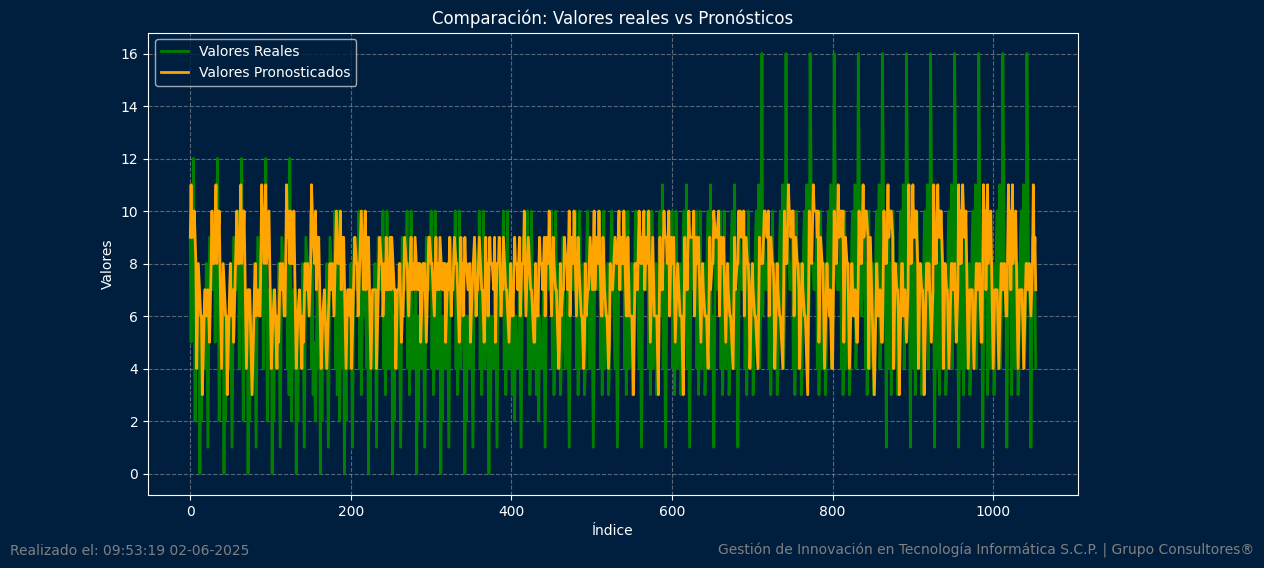

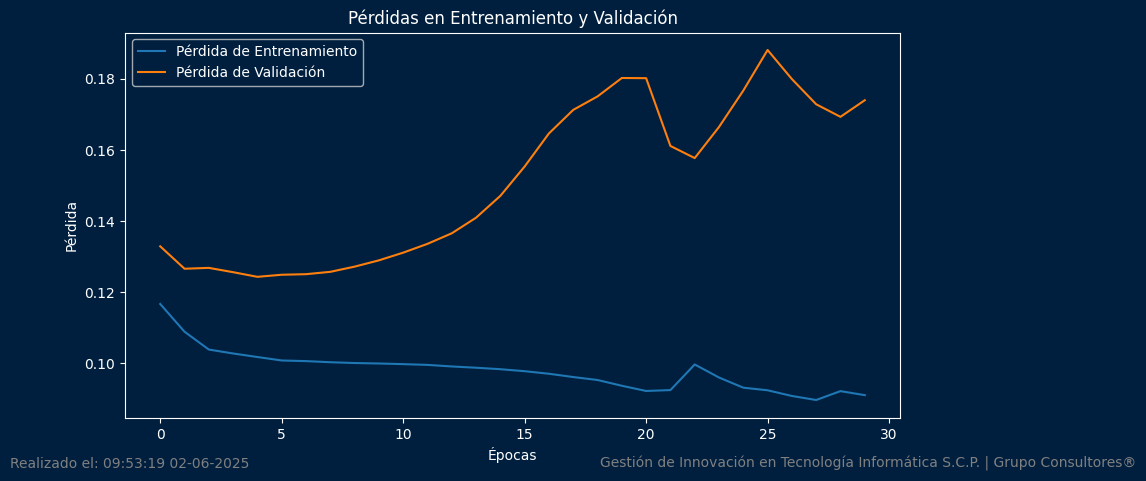

KeyError: 'data_size'

In [36]:
    all_predictions = createModels(data_trat,productKeyIds,'ProductKey',all_columns,n_features,isSelledCol,features,target_col,category_id)

In [ ]:
    # n_products = len(productKeyIds)
    # # data_trat =  data_trat.reset_index()

    # #agrupamos por ProductKey
    # seriesGB = data_trat.groupby('ProductKey')
    # all_columns_l = all_columns.copy()
    # all_columns_l.remove('ProductKey')

    # #Por cada producto
    # for pk in productKeyIds:
    #     print("El PK es: ",pk)

    #     #creamos un modelo
    #     model = create_model(n_features)

    #     #Obtener data de acuerdo al product key
    #     pkSeries = seriesGB.get_group(str(pk)).copy()

    #     # pd.set_option('display.max_rows', None)     # Muestra todas las filas
    #     # pd.set_option('display.max_columns', None)  # Muestra todas las columnas
    #     # pd.set_option('display.width', None)        # No trunca el ancho
    #     # pd.set_option('display.max_colwidth', None) # No trunca el contenido de celdas

    #     # Ahora imprime el DataFrame completo
    #     # print(pkSeries)
    #     # break

    #     #eliminar la columna de productkey
    #     pkSeries = pkSeries.drop(['ProductKey'], axis=1)

    #     #Pasamos por create x_y_train
    #     x_train, y_train, x_val, y_val, df, scaler_y, scaler, only_scaled = create_x_y_train(pkSeries, isSelledCol, all_columns_l,features, target_col)

    #     only_scaled.remove(target_col)

    #     #eliminar la columna de OrderQuantity después del escalado si no la necesitas más adelante
    #     pkSeries = pkSeries.drop([target_col], axis=1)

    #     # Obtener los últimos 32 registros
    #     last_32 = pkSeries.tail(int(PASOS+1)).copy()
    #     temp = pkSeries.tail(int(PASOS+1)).copy()

    #     if ISFLOATDATA:
    #         #convertimos a punto flotante
    #         last_32 = last_32.astype('float32')
    #         temp = temp.astype('float32')

    #     # print(last_32)
    #     # print(temp)

    #     # Asegúrate de que OrderQuantity esté presente para el escalado
    #     if target_col not in last_32.columns:
    #         last_32[target_col] = 0  # o el último valor conocido si lo prefieres

    #     # Asegúrate de que las columnas para el escalado coincidan con las usadas en el fit
    #     scaler_fit_columns = scaler.feature_names_in_ if hasattr(scaler, "feature_names_in_") else only_scaled
    #     temp[scaler_fit_columns] = scaler.transform(last_32[scaler_fit_columns])

    #     #Entrenamos el modelo
    #     model = train_model(x_train,y_train,x_val,y_val,model)

    #     # Realizar las predicciones multistep para los N_PREDICTIONS días futuros
    #     # Usamos los últimos PASOS registros escalados como ventana inicial

    #     # Asegurarse de que temp tiene al menos PASOS filas
    #     if temp.shape[0] < PASOS:
    #         raise ValueError(f"Not enough rows in temp to create input window: {temp.shape[0]} rows, need {PASOS}")

    #     # Seleccionar solo las columnas de features usadas por el modelo
    #     temp_for_pred = temp[features].tail(PASOS)
    #     x_input = temp_for_pred.to_numpy().reshape((1, PASOS, n_features))
    #     predicciones = []

    #     # Realizar la predicción multistep (la salida es de tamaño N_PREDICTIONS)
    #     pred = model.predict(x_input, verbose=0)  # pred.shape = (1, N_PREDICTIONS) or (1, N_PREDICTIONS, 1)
    #     # Si pred es 3D, reducir a 2D
    #     if pred.ndim == 3:
    #         pred_2d = pred.reshape(pred.shape[0], pred.shape[1])
    #     else:
    #         pred_2d = pred
    #     y_pred_inv = scaler_y.inverse_transform(pred_2d)  # y_pred_inv.shape = (1, N_PREDICTIONS)

    #     # Distribuir las predicciones individuales en la lista
    #     predicciones = y_pred_inv.flatten().tolist()

    #     print(predicciones)

    #     # for i in range(N_PREDICTIONS):
    #     #     # Predecir el siguiente paso
    #     #     pred = model.predict(x_input, verbose=0)
    #     #     # Si la salida es multistep, tomar solo el último valor predicho
    #     #     if pred.shape[-1] > 1:
    #     #         pred_value = pred[0, -1]
    #     #     else:
    #     #         pred_value = pred[0][0]
    #     #     # Desescalar la predicción
    #     #     pred_original = scaler_y.inverse_transform(np.array(pred_value).reshape(1, -1))[0][0]
    #     #     predicciones.append(pred_original)

    #     #     # Actualizar la ventana de entrada con la nueva predicción
    #     #     # Creamos un nuevo vector con las features, pero solo actualizamos el target
    #     #     nuevo = x_input[0, 1:, :].copy()
    #     #     nuevo_ultimo = x_input[0, -1, :].copy()

    #     #     # El target_col está en la misma posición que en only_scaled
    #     #     idx_target = all_columns_l.index(target_col)
    #     #     nuevo_ultimo[idx_target] = pred[0][-1] if pred.shape[-1] > 1 else pred[0][0]

            
    #     #     # Añadir la nueva fila al final
    #     #     x_input = np.concatenate([nuevo, nuevo_ultimo.reshape(1, -1)], axis=0).reshape((1, PASOS, n_features))

    #     # for prd in predicciones:
    #     #     print("Predicciones para el producto", pk, ":", prd)
    #     # Obtener la serie histórica real para el mismo producto y rango de fechas
    #     # Usamos prepData para obtener los datos reales históricos
    #     # historyData = prepData[prepData['ProductKey'] == pk][['OrderQuantity']].copy()
    #     historyData.index = pd.to_datetime(historyData.index)


    #     # Crear rango de fechas futuras para las predicciones
    #     last_date = temp_for_pred.index[-1]
    #     future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=len(predicciones), freq='D')

    #     # Selecciona el mismo rango de fechas que las predicciones para los datos reales
    #     # Mostramos los últimos 31 días históricos y los 31 días futuros predichos
    #     historyData_plot = historyData.loc[historyData.index <= last_date].tail(len(predicciones))
        

    #     plt.figure(figsize=(12, 6))
    #     plt.plot(historyData.index, historyData['TotalVentas'], label='Real', marker='o')
    #     plt.plot(future_dates, predicciones, marker='o', label=f'Predicciones PK {pk}')

        
    #     xticks = list(historyData.index[-len(predicciones):]) + list(future_dates)
    #     xticks = pd.to_datetime(xticks)
    #     step = max(1, len(xticks) // 10)  # máximo 10 etiquetas
    #     plt.xticks(xticks[::step], rotation=45)

    #     plt.title(f'Predicciones multistep para ProductKey {pk}')
    #     plt.xlabel('Fecha')
    #     plt.ylabel('OrderQuantity (desescalado)')
    #     plt.figtext(0.01,0.01,"Predicciones realizadas con el modelo: LSTM", fontsize=10,color="gray")
    #     plt.figtext(0.60,0.01,"Gestión de Innovación en Tecnología Informática S.C.P. | Grupo Consultores®", fontsize=10, color="gray")
    #     plt.figtext(0.40,0.01, "SIPPBST V2.0")
    #     plt.legend()
    #     plt.grid(True)
    #     plt.tight_layout()
    #     plt.show()    
    #     break

In [ ]:
    # predicciones

In [ ]:
    # #Es recomendable tener el precio de cada producto actualizado, ya que será necesario para recrear las series temporales de cada producto    
    # # with get_sqlconnection

    # tt_predictions = {}
    # df = dfg.reset_index()

    # sldw = []

    # #Antes, deberemos comprobar que registros si tienen los timeSteps disponibles
    # for productID in productKeyIds:
    #     # print("iniciando con el producto: ",productID)
    #     # Filtrar los datos para el producto actual y hacemos una copia para que no afecte el original
    #     serie = df[df['ProductKey'] == productID].copy()

    #     #Obtener la última venta realizada (puede venir de la metadata)
    #     lastDay = pd.Timestamp(last_day)

    #     #generar los 31 días anteriores a la última fecha de entrenamiento del modelo
    #     firstDay = lastDay - pd.Timedelta(days=31)
    #     firstDay = pd.Timestamp(firstDay)

    #     # print("firstday: ",firstDay)
    #     # print("lastDay: ",lastDay)


    #     #convertir la columna date a Datetime
    #     serie['Date'] = pd.to_datetime(serie['Date'], errors='coerce')

    #     #Ordenamos las fechas en orden cronológico de lo registrado por las ventas
    #     serie = serie.sort_values('Date')

    #     #Tomamos solo las ventas que esten en ese rango
    #     #Filtramos los valores
    #     serie = serie[(serie['Date'] >= firstDay) & (serie['Date'] <= lastDay)]

    #     # print(serie)
        
    #     # print("serie: ",productID," total: ",(len(serie.values)))

    #     # break

    #     # Crear rango fijo de fechas (últimos 31 días antes de la fecha de predicción)
    #     precitions_days = pd.date_range(start=firstDay, end=lastDay - pd.Timedelta(days=1), freq='D')
        
    #     #setear el index de serie
    #     serie_indexada = serie.set_index('Date')

    #     # Reindexar para garantizar continuidad temporal (rellenar días faltantes)
    #     serie_reindex = serie_indexada.reindex(precitions_days)

        
    #     serie_reindex = serie_reindex.reset_index()

    #     # print(serie_reindex)

    #     # break

    #     #En teoría ya hay las columnas, solo es rellenar con las que hacen falta
    #     serie_reindex['YEAR'] = serie_reindex['index'].dt.year
    #     serie_reindex['MONTH'] = serie_reindex['index'].dt.month
    #     serie_reindex['Day'] = serie_reindex['index'].dt.day
    #     serie_reindex['DayOfWeek'] = serie_reindex['index'].dt.dayofweek
    #     serie_reindex['IsWeekend'] = serie_reindex['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

    #     #lo seteamos como index
    #     # serie_reindex = serie_reindex.set_index('index')
        
    #     # Rellenar valores faltantes de la columna target con 0
    #     serie_reindex[target_col] = serie_reindex[target_col].fillna(0)

    #     #Asegurarnos de que es de tipo int
    #     serie_reindex[target_col] = serie_reindex[target_col].astype(int)

    #     #Obtenemos el precio unitario
    #     precioUNitario = dataProduct[dataProduct['ProductKey'] == productID]['Price'].values[0]

    #     #obtenemos el envio
    #     precioEnvio = dataProduct[dataProduct['ProductKey'] == productID]['StandardCost'].values[0]

    #     #Rellenar el precio unitario
    #     serie_reindex['UnitPrice'] = serie_reindex['UnitPrice'].fillna(0.0)

    #     #Rellenar descuento unitario
    #     serie_reindex['UnitPriceDiscountPct'] = serie_reindex['UnitPriceDiscountPct'].fillna(0.0)

    #     #Rellenar descuento acumulado
    #     serie_reindex['DiscountAmount'] = serie_reindex['DiscountAmount'].fillna(0.0)

    #     #Rellenar el precio de envío
    #     serie_reindex['ProductStandardCost'] = serie_reindex['ProductStandardCost'].fillna(0.0)

    #     #rellenar las ventas 
    #     serie_reindex['SalesAmount'] = serie_reindex['SalesAmount'].fillna(0.0)
        
    #     # Agregar nuevamente el ProductKey
    #     serie_reindex['ProductKey'] = productID

    #     #INCLUIMOS UNA NUEVA COLUMNA QUE INDIQUE SI HAY VENTAS
    #     serie_reindex[isSelledCol] = serie_reindex[target_col].apply(lambda x: 1 if x > 0 else 0)

    #     #guardamos el archivo generado en un csv
    #     # serie_reindex.to_csv(f'serie_product_{productID}.csv', index=False)

    #     #hasta este punto nos aseguramos de que todos los datos tienen 31 pasos en el tiempo + 1 dato que servirá para generar el sliddingo window
    #     #fin del primer paso

    #     #============= PASO 2=============
    #     #Hacerlo pasar por series tu supervised para hacer la predicción
    #     lastDaysPID = serie_reindex.copy()
    #     temp = serie_reindex.copy()

    #     # #eliminamos datetime
    #     lastDaysPID = lastDaysPID.drop(['index'], axis=1)
    #     temp = temp.drop(['index'], axis=1)

    #     # #convertimos a punto flotante
    #     lastDaysPID = lastDaysPID.astype('float32')
    #     temp = temp.astype('float32')

    #     # #devolvemos el formato
    #     lastDaysPID['index'] = serie_reindex['index']
    #     temp['index'] = serie_reindex['index']

    #     #escalamos las columnas solamente
    #     temp[only_scaled] = scaler.fit_transform(lastDaysPID[only_scaled])

    #     lastDaysPID_scaled = temp.copy()

    #     # lastDaysPID_scaled = scaler.fit_transform(lastDaysPID)

    #     # #seteamos como index
    #     lastDaysPID =  lastDaysPID.set_index('index')
        
    #     #lo convertimos a un dataframe
    #     lastDaysPID_scaled_1 = pd.DataFrame(lastDaysPID_scaled, columns=all_columns)

    #     #Creamos los slidding window
    #     X,_ = split_sequences(lastDaysPID_scaled_1, PASOS, features, target_col)

    #     #escalamos los datos 
    #     x_input = X[-1].reshape((1, PASOS, len(features)))


    #     #hacemos la preparación de las ventas con predicciones multistep
    #     # predictions = []
    #     predictions = model.predict(x_input)
    #     original_prediction = scaler_y.inverse_transform(predictions)
    #     original_prediction = original_prediction.astype(int)
    #     print(original_prediction)
    #     break  

    #     # for i in range(N_PREDICTIONS):
    #     #     prediction = model.predict(x_input)
    #     #     original_prediction = scaler_y.inverse_transform(prediction)
    #     #     original_prediction = original_prediction.astype(int)
    #     #     predictions.append(original_prediction[0][0])
    #     #     x_input = addNewValue(x_input, prediction[0])
    #     #guardamos las predicciones
    #     tt_predictions[productID] = original_prediction
    #     #eliminamos la referencia a memoria
    #     del serie
    #     del serie_reindex
    #     del lastDaysPID

In [ ]:
    # tt_predictions

In [ ]:
    
    # #============= PASO 3 ===============
    # #Hacer el cálculo y suma de todos los prodúctos vendidos y cuantos se vendieron por día
    # print(last_day)

    # # Crear un rango de fechas basado en el número de predicciones
    # days = pd.date_range(start=last_day, periods=N_PREDICTIONS, freq='D')

    # #iniciar un dataframe que almacene las predicciones diarias
    # general_day_predictions = pd.DataFrame({'Date':days, 'OrderQuantity':0})

    # #sumar las predicciones de todos los productos para cada día
    # # Sumar las predicciones de todos los productos para cada día
    # for productID, predictions in tt_predictions.items():
    #     print(predictions)
    #     # Asegurarse de que predictions sea un arreglo unidimensional
    #     predictions = predictions.flatten()  # Aplanar el arreglo (de (1, 31) a (31,))
        
    #     # Convertir predictions a una serie con el mismo índice que general_day_predictions
    #     predictions_series = pd.Series(predictions, index=general_day_predictions.index[:len(predictions)])
    #     general_day_predictions['OrderQuantity'] += predictions_series

In [ ]:
    # print(general_day_predictions)

In [ ]:
    # future_data = set_index_datetime(general_day_predictions)
    # prepData = historyData
    # prepData.index = pd.to_datetime(historyData.index)
    # future_data.index = pd.to_datetime(future_data.index)
    # start_date = '2013-11-30'
    # end_date = '2013-12-31'

    # # Filtra los datos por rango de fechas
    # filtered_data = prepData.loc[start_date:end_date]

    # plt.plot(filtered_data.index, filtered_data['TotalVentas'],label='Historial {p0} - {p1}'.format(p0=str(first_day.year), p1= str(last_day.year-1)))
    # plt.plot(future_data.index, future_data['OrderQuantity'],label='Predicción {p0}'.format(p0=str(last_day.year)))
    # xtics = filtered_data.index.union(future_data.index)[::4]

    # plt.xlabel('Fecha')
    # plt.ylabel('Cantidad de productos vendidos')
    # plt.title('Predicción de la demanda global por meses para el {p0}'.format(p0=str(last_day.year)))
    # plt.figtext(0.01,0.01,"Predicciones realizadas con el modelo: LSTM", fontsize=10,color="gray")
    # plt.figtext(0.60,0.01,"Gestión de Innovación en Tecnología Informática S.C.P. | Grupo Consultores®", fontsize=10, color="gray")
    # plt.figtext(0.40,0.01, "SIPPBST V2.0")



    # plt.legend()
    # plt.show()